Abstract

This program seeks to train a model that will perform better than a dummy model for predicting when the entity who is blamed the most for load shedding in Karachi, Pakistan will be blamed based on tweets blaming other entities.  We will use model selection techniques to determine if we have a model that meets this criteria or we will determine which of the models we have that performs the best.  

We will cover the logic applied in the code step by step to ensure a good understanding of how this program can be applied to quickly determine who is being blamed for load shedding in Karachi. In the first section, we will cover how to get the data.  The next section is the analysis portion, and finally I will cover my conclusions based on the data.  

Some interesting observations include that the times the entities are blamed is not normally distributed, so we may have to do some extra work if we require normalized data and the lasso regression performed worse than logistic regression.  A secondary use case for this code could be to determine if load shedding has recently occurred in Karachi or if it is becoming more or less of a problem.  

Gathering Data

First, we import the modules we will need and gather the API keys for the Twitter module.  We also initialize some variables that we will need later.

In [ ]:
# Modules we will need
import config
import datetime as DT
import twitter
import pandas as pd
import numpy as np

# Pulling credentials for python-twitter API
api = twitter.Api(consumer_key = config.api_key, consumer_secret = config.api_key_secret, access_token_key = config.access_token, access_token_secret = config.access_secret)

# Create variables that use datetime module to find today and one week ago
today = DT.date.today()
week_ago = today - DT.timedelta(days = 7)

# The search criteria we will need for all raw_query GetSearch twitter pulls
static_search = 'q=load shedding karachi'

# Create a list of all blamed entities in our program
blamed_list = ['Karachi Electric', 'Imran Khan', 'Asad Umar', 'NEPRA', 'Sui Gas', 'Naeem Rehman', 'Omar Ayub Khan', 'Tehreeki Insaaf']

In this cell, we set up three functions that we will need later.

In [428]:
# Set up the functions that we will need.

def name_setter(search):
    '''Returns set of twitter usernames who tweeted specified search criteria using GetSearch raw_query.  Contains no duplicates.'''
    name_set = {tweet.user.screen_name for tweet in search}
    return name_set

def name_set_length_lister(name_set_list):
    '''Returns a list of the lengths of a passed iterable.'''
    name_set_length_list = [len(name_set) for name_set in name_set_list]
    return name_set_length_list

def name_mbr_test(name_set_list, names):
    '''Returns dictionary of membership tests between two iterables.'''
    name_dict = {}
    for name in names:
        if name in name_set_list:
            name_dict[name] = True           
        else:
            name_dict[name] = False
    return name_dict    

This cell is where the actual searches take place.  We take the API key authority that we set up earlier and perform a GetSearch Twitter API search that includes the static search variable we set up to search for tweets about Karachi load shedding.  The extra search criteria in each search that comes immediately after the static search is based on a manual scan of how tweeters seemed to be blaming the entities.

Next, is the logic for the time frame we are trying to pull from.  Here we are pulling all tweets from today and going back one week.  This is the maximum available historical pull we can do with the Twitter API.  Next, we set the total tweet count we are pulling to 100, the maximum allowed for the Twitter API.

The next step that I want to take in this code is to create a more automated way to find the individualized search criteria.

In [429]:
# Search criteria for Karachi load shedding.

ke_search = api.GetSearch(raw_query = f'{static_search} #KE until%3A{today} since%3A{week_ago}&count=100')
KElectricPk_search = api.GetSearch(raw_query = f'{static_search} %40KElectricPk until%3A{today} since%3A{week_ago}&count=100')
imran_khan_search = api.GetSearch(raw_query = f'{static_search} %40ImranKhanPTI until%3A{today} since%3A{week_ago}&count=100')
asad_umar_search = api.GetSearch(raw_query = f'{static_search} %40Asad_Umar until%3A{today} since%3A{week_ago}&count=100')
nepra_search = api.GetSearch(raw_query = f'{static_search} #NEPRA until%3A{today} since%3A{week_ago}&count=100')
sui_search = api.GetSearch(raw_query = f'{static_search} sui until%3A{today} since%3A{week_ago}&count=100')
naeem_rehman_search = api.GetSearch(raw_query = f'{static_search} %40NaeemRehmanEngr until%3A{today} since%3A{week_ago}&count=100')
omar_ayub_khan_search = api.GetSearch(raw_query = f'{static_search} %40OmarAyubKhan until%3A{today} since%3A{week_ago}&count=100')
PTI_government_search = api.GetSearch(raw_query = f'{static_search} #PTI_government until%3A{today} since%3A{week_ago}&count=100')

In this cell, we apply the name_setter function that we created to all of the searches. The name_setter function finds all of the tweeters in the search and puts them into a set, which automatically removes duplicate names from the set. Removing duplicate names allows us to see individual "blames" against any entity that we can use to count as blames. It wouldn't make sense to gather multiple tweets by the same tweeter if what we are looking for is a case of one person blaming an entity.

In [513]:
# Take twitter user names for all of the searches
ke_set = name_setter(ke_search)
KElectricPk_set = name_setter(KElectricPk_search)
karachi_electric_set = ke_set.union(KElectricPk_set)
imran_khan_set = name_setter(imran_khan_search)
asad_umar_set = name_setter(asad_umar_search)
nepra_set = name_setter(nepra_search)
sui_set = name_setter(sui_search)
naeem_rehman_set = name_setter(naeem_rehman_search)
omar_ayub_khan_set = name_setter(omar_ayub_khan_search)
PTI_set = name_setter(PTI_government_search)

In this cell, we set up a list of the sets we created and conduct a union to merge all of the names from all of the sets together to perform more analysis.  In this case, we also want to remove the duplicate names when we merge all of the sets together, so we merge the names into a set.

In [431]:
# Initiate a list of sets
name_set_list = [karachi_electric_set, imran_khan_set, asad_umar_set, nepra_set, sui_set, naeem_rehman_set, omar_ayub_khan_set, PTI_set]

# Combine all sets from name_set_list and leave into one set
blamer_set = set.union(*name_set_list)

In this cell, we create a dictionary out of the blamed list we created and the length of the name_set_list, which represents the total number of blames per entity.

In [432]:
# Find the length of the name_set_list
name_set_lengths = name_set_length_lister(name_set_list)

# Create a dictionary of the blamed entities and the number of times each entity is blamed
blamed_dict = dict(zip(blamed_list, name_set_lengths))
print(blamed_dict)

{'Karachi Electric': 12, 'Imran Khan': 1, 'Asad Umar': 0, 'NEPRA': 12, 'Sui Gas': 0, 'Naeem Rehman': 0, 'Omar Ayub Khan': 0, 'Tehreeki Insaaf': 12}


In this cell, we take the blamer_set and make it a list to apply to our membership tests.  We turn all the sets into lists to avoid complications with looping through the sets when receiving duplicates.  The name_mbr_test function loops throug the blame_list to determine if a name from the blame_list is in the the specified list and returns a single dictionary with names and True/False values.  Finally, we put all of the membership test dictionaries into a list.

In [433]:
# Turn the set into a list
blame_list = list(blamer_set)


# Membership tests for all name sets
karachi_electric_blame_test = name_mbr_test(list(karachi_electric_set), blame_list)
imran_khan_blame_test = name_mbr_test(list(imran_khan_set), blame_list)
asad_umar_blame_test = name_mbr_test(list(asad_umar_set), blame_list)
nepra_blame_test = name_mbr_test(list(nepra_set), blame_list)
sui_blame_test = name_mbr_test(list(sui_set), blame_list)
naeem_rehman_blame_test = name_mbr_test(list(naeem_rehman_set), blame_list)
omar_ayub_khan_blame_test = name_mbr_test(list(omar_ayub_khan_set), blame_list)
PTI_blame_test = name_mbr_test(list(PTI_set), blame_list)

# Make sure we are getting a dictionary back
print(type(karachi_electric_blame_test))

# Make a list of all blame tests
blame_test_list = [karachi_electric_blame_test, imran_khan_blame_test, asad_umar_blame_test,\
                   nepra_blame_test, sui_blame_test, naeem_rehman_blame_test, omar_ayub_khan_blame_test, PTI_blame_test]


<class 'dict'>


In this cell we turn the blamed_dict dictionary into a pandas Series. Observing the output, we can see some entities who were blamed the previous code Karachi_Load_Shedding_Blame_Game have not been blamed recently.

In [434]:
# Create a pandas Series out of the dictionary
times_blamed = pd.Series(blamed_dict)
times_blamed

Karachi Electric    12
Imran Khan           1
Asad Umar            0
NEPRA               12
Sui Gas              0
Naeem Rehman         0
Omar Ayub Khan       0
Tehreeki Insaaf     12
dtype: int64

In this cell we see the total blames and the average times an entity in the dataset is blamed.

In [435]:
# Print the total and average of the times_blamed Series
print(f'The total times all entities in the dataset have been blamed for load shedding in Karachi, Pakistan is {sum(times_blamed)}.')
print(f'The average number of times the entities in the dataset have been blamed for load shedding in Karachi, Pakistan is {np.mean(times_blamed)}.')


The total times all entities in the dataset have been blamed for load shedding in Karachi, Pakistan is 37.
The average number of times the entities in the dataset have been blamed for load shedding in Karachi, Pakistan is 4.625.


A histogram of the data suggests that there is a right skew to the distribution.  One way we could try to fix this would be to combine the members of entities into their appropriate entity, such as Imran Khan, the current Prime Minister of Pakistan, who is the leader of the Tehreeki Insaaf political party.

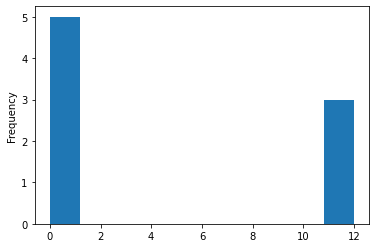

In [436]:
# Plot a histogram of the times_blamed Series
times_blamed.plot.hist()

In this cell we make the histogram more normalized by simply dropping rows.

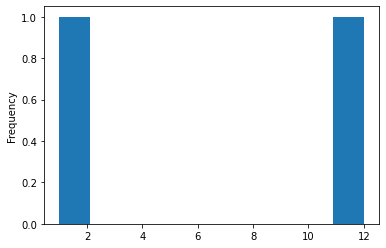

In [515]:
# Drop a few rows of the times_blamed Series to make it more normalized
normalized_times_blamed = times_blamed.drop(['NEPRA', 'Tehreeki Insaaf', 'Sui Gas', 'Asad Umar', 'Omar Ayub Khan', 'Naeem Rehman'])
normalized_times_blamed.plot.hist()


The bar chart shows us more clearly of which entities are receiving the most blame. It seems Karachi Electric, NEPRA, and Tehreeki Insaaf are being blamed more than other entities at this time.

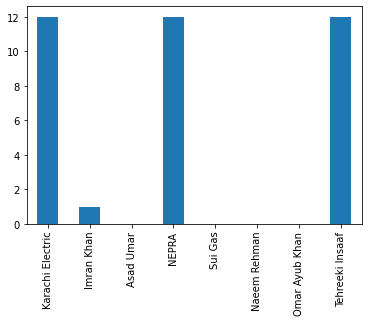

In [438]:
# Plot a bar chart for the times_blamed Series
times_blamed.plot.bar(legend = False)

In this cell, we create a pandas DataFrame out of the membership test dictionaries, which shows how much each individual is blaming different entities.  We mask the names with generic terms to protect the identities of those who have blamed the entities.  The theory is that we can use these occurences to determine the likelihood of a tweeter blaming one entity if they blame another and potentially predicting if an entity will be blamed based on the other entities being blamed.

In [439]:
# Create a dataframe out of the membership tests
karachi_ls_df = pd.DataFrame(blame_test_list, index = blamed_list)

# Set column names to Tweeter plus the column index
karachi_ls_df.columns = ['Tweeter' + str(x) for x in range(0, len(karachi_ls_df.columns))]
karachi_ls_df

,Tweeter0,Tweeter1,Tweeter2,Tweeter3,Tweeter4,Tweeter5,Tweeter6,Tweeter7,Tweeter8,Tweeter9,Tweeter10,Tweeter11
Karachi Electric,True,True,True,True,True,True,True,True,True,True,True,True
Imran Khan,False,False,False,False,False,False,False,False,False,False,False,True
Asad Umar,False,False,False,False,False,False,False,False,False,False,False,False
NEPRA,True,True,True,True,True,True,True,True,True,True,True,True
Sui Gas,False,False,False,False,False,False,False,False,False,False,False,False
Naeem Rehman,False,False,False,False,False,False,False,False,False,False,False,False
Omar Ayub Khan,False,False,False,False,False,False,False,False,False,False,False,False
Tehreeki Insaaf,True,True,True,True,True,True,True,True,True,True,True,True


In this cell, we create a random sample of 10 columns that we can use in further analysis.

In [440]:
# Create a separate dataframe consisting of 10 random samples of the columns
sample_karachi_ls_df = karachi_ls_df.sample(n=10, axis=1)

Here we find the counts of True and False within the samples we pulled.

In [441]:
# Find a count of all True values and all False values in the sample
unique_sample = np.unique(sample_karachi_ls_df, return_counts = True)
print(unique_sample)

(array([False,  True]), array([49, 31], dtype=int64))


In this cell we create a bar graph plotting the observations in the sample.  We can see that there is a clear trend of many more False than True.  This helps us visualize that most tweeters blamed just a few of the entities and not most or all of them.

[Text(0, 0.5, 'Occurences in sample'), Text(0.5, 0, 'True/False')]

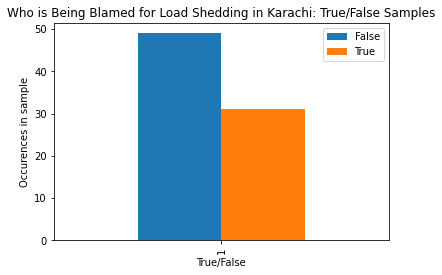

In [442]:
# Create a dataframe out of the True/False numpy array
unique_sample_df = pd.DataFrame(unique_sample)

# Rename the columns after the first row
unique_sample_df.rename(columns=unique_sample_df.iloc[0], inplace = True)

# Remove the old first row
unique_sample_df.drop([0], inplace = True)

# Create a bar chart out of the False/True sample
ax = unique_sample_df.plot.bar(title = 'Who is Being Blamed for Load Shedding in Karachi: True/False Samples')
ax.set(xlabel = 'True/False', ylabel = 'Occurences in sample')

In this cell, we are combining the new data above with previously recorded data saved in a csv file.

In [443]:
# Take previous data stored in csv
karachi_load_shedding = pd.DataFrame(pd.read_csv('karachi_ls_tweeters'))
karachi_load_shedding = karachi_load_shedding.set_index('Unnamed: 0')
karachi_load_shedding.index.name = ''

# Combine the dataframes into one
frames = [karachi_load_shedding, karachi_ls_df]
kls_df = pd.concat(frames, axis = 1)
kls_df.columns = ['Tweeter' + str(x) for x in range(0, len(kls_df.columns))]

# Turn True/False values into integers
kls_df = kls_df * 1

# Change index name
kls_df.index.name = 'Blamed'
kls_df

,Tweeter0,Tweeter1,Tweeter2,Tweeter3,Tweeter4,Tweeter5,Tweeter6,Tweeter7,Tweeter8,Tweeter9,...,Tweeter49,Tweeter50,Tweeter51,Tweeter52,Tweeter53,Tweeter54,Tweeter55,Tweeter56,Tweeter57,Tweeter58
Blamed,,,,,,,,,,,,,,,,,,,,,
Karachi Electric,1,0,1,1,1,1,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
Imran Khan,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
Asad Umar,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NEPRA,1,0,0,1,1,1,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
Sui Gas,0,0,0,0,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
Naeem Rehman,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Omar Ayub Khan,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Tehreeki Insaaf,1,0,0,1,1,1,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1


Karachi Electric has the most blames overall.

In [512]:
# Find who is being blamed the most
def who_is_to_blame(alist, df):
    '''Iterates over a list and prints the item in the list followed by 
    unique counts in a numpy array.'''
    for b in alist:
        array = f'{b}:', np.unique(df.loc[b], return_counts = True)
        print(array)

who_is_to_blame(blamed_list, kls_df)

('Karachi Electric:', (array([0, 1]), array([25, 34], dtype=int64)))
('Asad Umar:', (array([0, 1]), array([55,  4], dtype=int64)))
('NEPRA:', (array([0, 1]), array([33, 26], dtype=int64)))
('Sui Gas:', (array([0, 1]), array([33, 26], dtype=int64)))
('Naeem Rehman:', (array([0, 1]), array([57,  2], dtype=int64)))
('Omar Ayub Khan:', (array([0, 1]), array([58,  1], dtype=int64)))
('Tehreeki Insaaf:', (array([0, 1]), array([33, 26], dtype=int64)))


For the purposes of this project, we will drop all of the people, who have just a few blames and leave the entities, which all have many blames.

In [445]:
# Create a new dataframe with only the entities that we want
new_kls_df = kls_df.drop('Imran Khan').drop('Asad Umar').drop('Naeem Rehman').drop('Omar Ayub Khan')
new_kls_df

,Tweeter0,Tweeter1,Tweeter2,Tweeter3,Tweeter4,Tweeter5,Tweeter6,Tweeter7,Tweeter8,Tweeter9,...,Tweeter49,Tweeter50,Tweeter51,Tweeter52,Tweeter53,Tweeter54,Tweeter55,Tweeter56,Tweeter57,Tweeter58
Blamed,,,,,,,,,,,,,,,,,,,,,
Karachi Electric,1,0,1,1,1,1,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
NEPRA,1,0,0,1,1,1,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
Sui Gas,0,0,0,0,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
Tehreeki Insaaf,1,0,0,1,1,1,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1


In [488]:
# Make a new blamed list
new_blamed_list = ['Karachi Electric', 'NEPRA', 'Sui Gas', 'Tehreeki Insaaf']

In [490]:
# Call who_is_to_blame function on the new list and dataframe
who_is_to_blame(new_blamed_list, new_kls_df)

('Karachi Electric:', (array([0, 1]), array([25, 34], dtype=int64)))
('NEPRA:', (array([0, 1]), array([33, 26], dtype=int64)))
('Sui Gas:', (array([0, 1]), array([33, 26], dtype=int64)))
('Tehreeki Insaaf:', (array([0, 1]), array([33, 26], dtype=int64)))


Ideally, we will find a model that performs better than Karachi Electric's True/False ratio of 0.576.

In [491]:
# Karachi Electric dummy model
print(34/(34+25))

0.576271186440678


In [447]:
# Splitting the data into training data and test data
from sklearn.model_selection import train_test_split


X = new_kls_df[1:4].to_numpy().reshape(59, 3)
y = new_kls_df.loc['Karachi Electric'].to_numpy().reshape(-1)
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.3, random_state = 1, stratify = y)

In [449]:
# Logistic Regression model
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(penalty = 'none', random_state = 1)
logreg.fit(Xtrain, ytrain)

LogisticRegression(penalty='none', random_state=1)

If no other entity is blamed, according to the logistic regression model, there is a 67% probability that Karachi Electric will be blamed.

In [450]:
# Make a prediction
X = np.array([[0, 0, 0]])
logreg.predict_proba(X)

array([[0.33046735, 0.66953265]])

In [451]:
# Find the coefficients for the logistic regression model
logreg.coef_

array([[-0.74355052,  0.20770785, -0.18194317]])

In [492]:
# Lasso regression model
from sklearn.linear_model import Lasso

lasso = Lasso(alpha = 5, max_iter = 1000000)
lasso.fit(Xtrain, ytrain)

Lasso(alpha=5, max_iter=1000000)

The Lasso model has wrangled all of the coefficients to 0.

In [493]:
# Get lasso model coefficients
lasso.coef_

array([-0., -0., -0.])

In [518]:
# Model Selection using Cross Validation on logistic regression model
from sklearn.model_selection import cross_validate

two_fold_log_select = cross_validate(estimator = logreg, X = Xtrain, y = ytrain, cv = 2, return_estimator = True, return_train_score = True)
two_fold_log_select

{'fit_time': array([0.00699663, 0.00599551]),
 'score_time': array([0.00099993, 0.00100136]),
 'estimator': (LogisticRegression(penalty='none', random_state=1),
  LogisticRegression(penalty='none', random_state=1)),
 'test_score': array([0.57142857, 0.55      ]),
 'train_score': array([0.6       , 0.61904762])}

In [519]:
two_fold_log_select['train_score']

array([0.6       , 0.61904762])

As expected, the train scores are higher than the test scores.

In [520]:
two_fold_log_select['test_score']

array([0.57142857, 0.55      ])

In [521]:
# Find the mean and standard deviation of the logistic regression model's test scores
log_select_mean = two_fold_log_select['test_score'].mean()

log_select_std = two_fold_log_select['test_score'].std()

Logistic Regression performed just under the dummy model's accuracy.

In [523]:
# Print the results of the mean and standard deviation for the logistic regression model's test scores
print('Logistic Regression 2 fold cv results (Accuracy) %.3f +/- %.3f'%(log_select_mean, log_select_std))

Logistic Regression 2 fold cv results (Accuracy) 0.561 +/- 0.011


In [526]:
# Model Selection using Cross Validation on lasso regression model
two_fold_lasso_select = cross_validate(estimator = lasso, X = Xtrain, y = ytrain, cv = 2, return_estimator = True, return_train_score = True)
two_fold_lasso_select

{'fit_time': array([0.00099778, 0.00099826]),
 'score_time': array([0.00100017, 0.00100136]),
 'estimator': (Lasso(alpha=5, max_iter=1000000),
  Lasso(alpha=5, max_iter=1000000)),
 'test_score': array([-0.125     , -0.11111111]),
 'train_score': array([0., 0.])}

In [527]:
two_fold_lasso_select['train_score']

array([0., 0.])

Again, train scores are higher than test scores.

In [528]:
two_fold_lasso_select['test_score']

array([-0.125     , -0.11111111])

In [529]:
# Find the mean and standard deviation of the lasso model's test scores
lasso_select_mean = two_fold_lasso_select['test_score'].mean()

lasso_select_std = two_fold_lasso_select['test_score'].std()

In this instance, the lasso model performed worse than logistic regression.

In [530]:
# Print the results of the mean and standard deviation for the lasso model's test scores
print('Lasso Regression 4 fold cv results (Accuracy) %.3f +/- %.3f'%(lasso_select_mean, lasso_select_std))

Lasso Regression 4 fold cv results (Accuracy) -0.118 +/- 0.007


Note in the graph below, the lasso model's train score does not appear because it is 0.

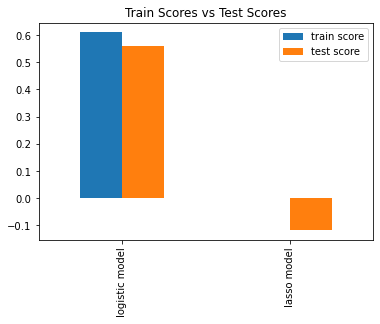

In [565]:
test_df = pd.DataFrame({'train score':[two_fold_log_select['train_score'].mean(), two_fold_lasso_select['train_score'].mean()],
                        'test score':[two_fold_log_select['test_score'].mean(), two_fold_lasso_select['test_score'].mean()]},
                       index = ['logistic model', 'lasso model'])
test_df.plot.bar(title = 'Train Scores vs Test Scores')

We were unable to train a model that would beat the dummy model's ability to predict when tweeters would blame Karachi Electric for load shedding in Karachi based on who else those tweeters were blaming.  The model that performed the best in the model selection process was logistic regression based on its average accuracy score of 0.56 compared to the lasso regression model's -0.246 average accuracy score.  However, I would not recommend using the model to predict blames against Karachi Electric because overall the accuracy of the model is too low.

In [566]:
kls_df.to_csv('karachi_ls.csv') 